# Tutorial: Cognitive Service Vision Planogram Compliance using Python

This is a tutorial about using Cognitive Service Vision Planogram Compliance. Cognitive Service Vision Planogram Compliance are tools to check planogram compliance using planogram and product recognition result

Currently, planogram compliance feature are available in **EastUS**, **West US2**, and **West Europe** regions.

Please create a computer vision resource on Azure portal, in **EastUS**, **West US2**, or **West Europe** region, if you don't already have one. You can use [Multi-service resource](https://learn.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account?tabs=multiservice%2Canomaly-detector%2Clanguage-service%2Ccomputer-vision%2Cwindows) as well. 

## Install the python samples package

Install the sample code including utility code helping you use Python to run planogram compliance in this tutorial.

In [ ]:
pip install cognitive-service-vision-product-recogntion-python-samples

## Credentials

Resource name and resource key are needed for accessing the service, which you can find here:

![check media/credentials.png if pic does not show up](./resources/credentials.png)

In [7]:
# Resource and key
import logging
logging.getLogger().setLevel(logging.INFO)
from cognitive_service_vision_model_customization_python_samples import ResourceType

resource_type = ResourceType.SINGLE_SERVICE_RESOURCE # or ResourceType.MULTI_SERVICE_RESOURCE

resource_name = None
multi_service_endpoint = None

if resource_type == ResourceType.SINGLE_SERVICE_RESOURCE:
    resource_name = '{specify_your_resource_name}'
    assert resource_name
else:
    multi_service_endpoint = '{specify_your_service_endpoint}'
    assert multi_service_endpoint

resource_key = '{specify_your_resource_key}'

## Prepare and load the planogram

A planogram, also known as a plano, POG, plan-o-gram, schematic, or visual description, is a detailed visual map that establishes the position of the merchandise within a retail store. It is often used in the retail industry as a tool for space planning and product placement. This diagram shows precisely where each item in a store should be placed in order to maximize customer purchases.

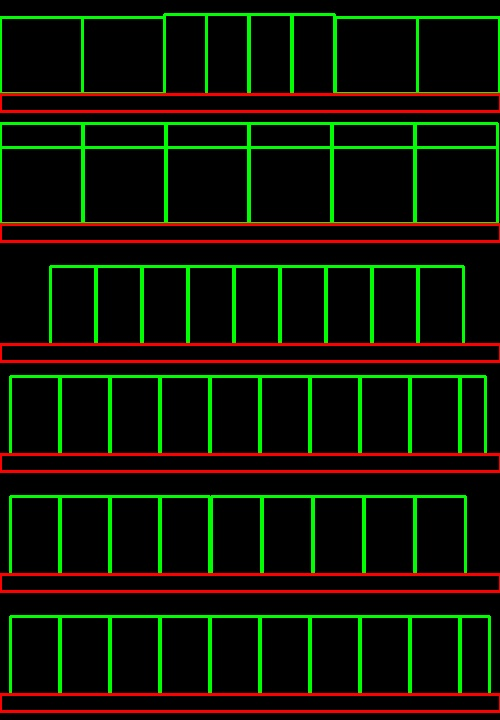

In [6]:
from cognitive_service_vision_model_customization_python_samples.tools import visualize_planogram
from IPython.display import Image

input_filename = './resources/sample_planogram.json'
output_filename = './resources/rendered_sample_planogram.jpg'
visualize_planogram(input_filename, output_filename)
Image(output_filename)

## Call product recognition

In [8]:
import uuid
from cognitive_service_vision_model_customization_python_samples.clients import ProductRecognitionClient
from cognitive_service_vision_model_customization_python_samples.models import ProductRecognition

client = ProductRecognitionClient(resource_type, resource_name, multi_service_endpoint, resource_key)
run_name = str(uuid.uuid4())
model_name = 'ms-pretrained-product-detection'
run = ProductRecognition(run_name, model_name)

with open('./resources/sample_image.jpg', 'rb') as f:
    img = f.read()

try:
    client.create_run(run, img, 'image/png')
    client.wait_for_completion(run_name, model_name)
finally:
    client.delete_run(run_name, model_name)

ConnectionError: HTTPSConnectionPool(host='%7bspecify_your_resource_name%7d.cognitiveservices.azure.com', port=443): Max retries exceeded with url: /computervision//productrecognition/ms-pretrained-product-detection/runs/5f694fe7-540f-44f1-9eb9-9bfc19d68342?api-version=2023-04-01-preview (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001DCBE402640>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

## Visualize the matching result